In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# PPI genes

# A549 cells alone

In [2]:
FDR_thres = .05

In [3]:
fpath = '../data/DEGs/DESeq2.A549.tsv'

df_a549 = pd.read_csv(fpath, sep='\t', index_col=0, header=0, dtype='object')
df_a549 = df_a549[df_a549['status']=='OK'].iloc[:,:6]
df_a549 = df_a549.astype('float')

df_a549 = df_a549[df_a549['padj'] < FDR_thres]
df_a549.shape

(120, 6)

In [4]:
df_a549.to_csv('../data/DEGs/FDR_select.DEGs.csv')

(100, 20)

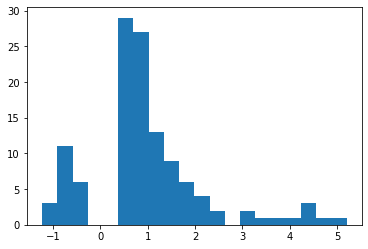

In [5]:
_ = plt.hist(df_a549['log2FoldChange'],bins=20)

up1,dn1 = df_a549[df_a549['log2FoldChange']>0],df_a549[df_a549['log2FoldChange']<0]
len(up1), len(dn1)

In [6]:
fname = '../data/gprofiler/A549.up.txt'
with open(fname, 'w') as f:
    for g in up1.index:
        f.write(f'{g}\n')

        
fname = '../data/gprofiler/A549.down.txt'
with open(fname, 'w') as f:
    for g in dn1.index:
        f.write(f'{g}\n')        

# Input genes
## to L1000CDS2

In [8]:
# from classification.xlsx; antiviral up & antiviral down
# antiviral = np.loadtxt('../data/cmap/antiviral.txt',dtype='object')
# from classification.xlsx; proviral up
proviral = np.loadtxt('../data/cmap/proviral.txt',dtype='object')

In [ ]:
antiviral_filter = [x for x in antiviral if x not in proviral]
proviral_filter = [x for x in proviral if x not in antiviral]

In [ ]:
len(antiviral), len(antiviral_filter), len(proviral), len(proviral_filter)

In [ ]:
immune = np.loadtxt('../data/cmap/immune.txt',dtype='object')
immune_filtered = [x for x in immune if x not in proviral]
len(immune_filtered)

In [ ]:
for x in immune_filtered:
    print(x)

In [ ]:
for x in antiviral_filter:
    print(x)

In [ ]:
for x in proviral: # not filtered, too few
    print(x)

# Plot filtered GO terms

## Enrich 

In [9]:
from gprofiler import GProfiler
from utils import *

In [30]:
def plot_enrich(data, n_terms=20, title=None, save=False, 
                fontsize=20, dpi=300, fmt='png', width=4, height=None): # 20 terms ~ default figsize
    import pandas as pd
    import numpy as np
    import matplotlib.pyplot as plt
    import seaborn as sb
    from matplotlib import colors
    from matplotlib import rcParams

    # Test data input
    if not isinstance(data, pd.DataFrame):
        raise ValueError('Please input a Pandas Dataframe output by gprofiler.')
        
    if not np.all([term in data.columns for term in ['p_value', 'name', 'intersection_size']]):
        raise TypeError('The data frame {} does not contain enrichment results from gprofiler.'.format(data))
        
    data_to_plot = data.iloc[:n_terms,:].copy()    
    data_to_plot['go.id'] = data_to_plot.index
    

    min_pval = data_to_plot['p_value'].min()
    max_pval = data_to_plot['p_value'].max()
    
    # Scale intersection_size to be between 5 and 75 for plotting
    #Note: this is done as calibration was done for values between 5 and 75
    data_to_plot['scaled.overlap'] = scale_data_5_75(data_to_plot['intersection_size'])
    
    norm = colors.LogNorm(min_pval, max_pval)
    sm = plt.cm.ScalarMappable(cmap="coolwarm", norm=norm)
    sm.set_array([])

    sb.set(style="whitegrid")
    height = data_to_plot.shape[0]*0.4
    rcParams.update({'font.size': fontsize,'figure.figsize':[width,height]})

    path = plt.figure()
    plt.scatter(x='recall', y="name", c='p_value', cmap='coolwarm', 
                       norm=colors.LogNorm(min_pval, max_pval), 
                       data=data_to_plot, linewidth=1, edgecolor="grey", 
                       s=[(i+10)**1.5 for i in data_to_plot['scaled.overlap']])
    
    ax = plt.gca()   
    ax.invert_yaxis()
    
    ax.tick_params(axis='both', which='major', labelsize=20)
    ax.tick_params(axis='both', which='minor', labelsize=8)

    ax.set_ylabel('')
    ax.set_xlabel('Gene ratio', fontsize=20, fontweight='normal')
    ax.xaxis.grid(False)
    ax.yaxis.grid(True)
    if title is not None:
        ax.set_title(title)

    # Shrink current axis by 20%
    box = ax.get_position()
    print('%d terms with height'%data_to_plot.shape[0], 'figsize', path.bbox_inches, 'box',box)
    
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

    # Get tick marks for this plot
    #Note: 6 ticks maximum
    min_tick = np.floor(np.log10(min_pval)).astype(int)
    max_tick = np.ceil(np.log10(max_pval)).astype(int)
    tick_step = np.ceil((max_tick - min_tick)/6).astype(int)
    
    # Ensure no 0 values
    if tick_step == 0:
        tick_step = 1
        min_tick = max_tick-1
    
    ticks_vals = [10**i for i in range(max_tick, min_tick-1, -tick_step)]
    ticks_labs = ['$10^{'+str(i)+'}$' for i in range(max_tick, min_tick-1, -tick_step)]

    #Colorbar
    fig = plt.gcf()
    cbaxes = fig.add_axes([0.8, 0.1, 0.03, 0.3])
    cbar = ax.figure.colorbar(sm, ticks=ticks_vals, shrink=0.5, anchor=(0,0.1), cax=cbaxes)
    cbar.ax.set_yticklabels(ticks_labs)
    cbar.set_label("Adjusted p-value", fontsize=15, fontweight='normal')

    #Size legend
    min_olap = data_to_plot['intersection_size'].min()
    max_olap = data_to_plot['intersection_size'].max()
    olap_range = max_olap - min_olap
    
    #Note: approximate scaled 5, 25, 50, 75 values are calculated
    #      and then rounded to nearest number divisible by 5
    size_leg_vals = [np.round(i/5)*5 for i in 
                          [min_olap, min_olap+(20/70)*olap_range, min_olap+(45/70)*olap_range, max_olap]]
    size_leg_scaled_vals = scale_data_5_75(size_leg_vals)

    
    l1 = plt.scatter([],[], s=(size_leg_scaled_vals[0]+10)**1, edgecolors='none', color='black')
    l2 = plt.scatter([],[], s=(size_leg_scaled_vals[1]+10)**1, edgecolors='none', color='black')
    l3 = plt.scatter([],[], s=(size_leg_scaled_vals[2]+10)**1, edgecolors='none', color='black')
    l4 = plt.scatter([],[], s=(size_leg_scaled_vals[3]+10)**1, edgecolors='none', color='black')

    labels = [str(int(i)) for i in size_leg_vals]

    plt.legend([l1, l2, l3, l4], labels, ncol=1, frameon=False, title_fontsize=20, fontsize=14,
                     handlelength=1, loc = 'upper left', borderpad = 1, labelspacing = .6,
                     handletextpad=2, title='Gene overlap', scatterpoints = 1,  bbox_to_anchor=(-2, 8.2/3), 
                     facecolor='black')

    if save:
        plt.savefig(save, dpi=dpi, format=fmt, bbox_inches='tight')
        
    else:
        plt.show()
        return plt.gca()

(16, 14)
Plotting selected enrichment for 100 Upregulated genes
16 terms with height figsize Bbox(x0=0.0, y0=0.0, x1=4.0, y1=6.4) box Bbox(x0=0.125, y0=0.125, x1=0.9, y1=0.88)


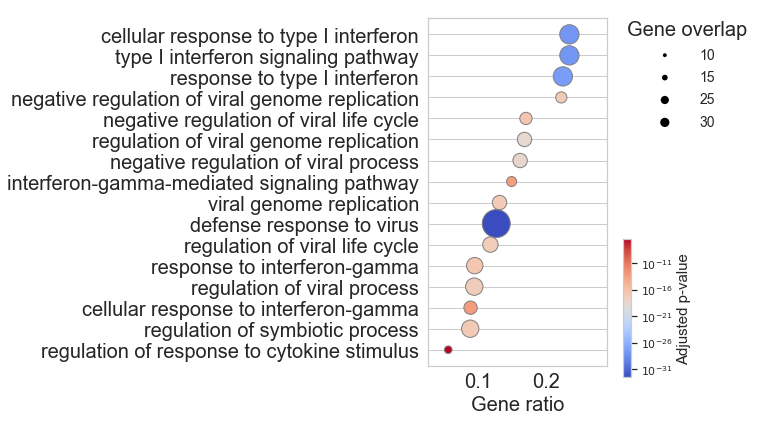

In [33]:
genes = list(np.loadtxt('../data/gprofiler/A549.up.txt',dtype='object'))

gp = GProfiler(return_dataframe=True)
enr = gp.profile(organism='hsapiens',query=genes,significance_threshold_method='fdr')

enr_sel = enr[(enr['source']=='GO:BP') & (enr['term_size']<=300) & (enr['intersection_size']>=10)].reset_index(drop=True).sort_values('recall', ascending=False)
print(enr_sel.shape)

print(f'Plotting selected enrichment for {len(genes)} Upregulated genes')
plot_enrich(enr_sel, title='', save=f'../figures/A549.filtered_GO.up.png', 
            fontsize=50, dpi=300)

In [11]:
gp.profile?

Plotting selected enrichment for 20 Upregulated genes
13 terms with height figsize Bbox(x0=0.0, y0=0.0, x1=4.0, y1=5.2) box Bbox(x0=0.125, y0=0.125, x1=0.9, y1=0.88)


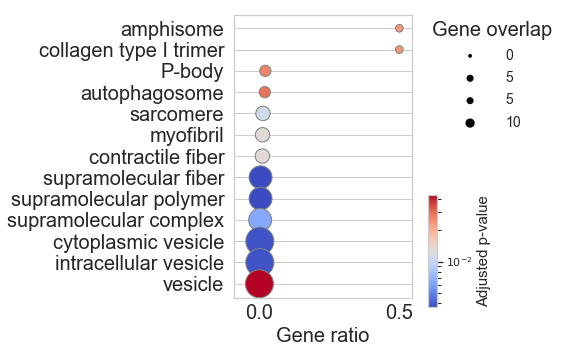

In [32]:
genes = list(np.loadtxt('../data/gprofiler/A549.down.txt',dtype='object'))

gp = GProfiler(return_dataframe=True)
enr = gp.profile(organism='hsapiens',query=genes,significance_threshold_method='fdr')

enr_sel = enr[enr['source']=='GO:CC'].reset_index(drop=True).sort_values('recall', ascending=False)

print(f'Plotting selected enrichment for {len(genes)} Upregulated genes')
plot_enrich(enr_sel, title='', save=f'../figures/A549.filtered_GO.down.png', dpi=300)

In [13]:
enr_sel

,source,native,name,p_value,significant,description,term_size,query_size,intersection_size,effective_domain_size,precision,recall,query,parents
8,GO:CC,GO:0044753,amphisome,0.023454,True,"""Intermediate organelles formed during macroau...",2,14,1,18856,0.071429,0.500000,query_1,[GO:0005776]
9,GO:CC,GO:0005584,collagen type I trimer,0.023454,True,"""A collagen trimer containing alpha(I) chains....",2,14,1,18856,0.071429,0.500000,query_1,[GO:0005583]
10,GO:CC,GO:0000932,P-body,0.026533,True,"""A focus in the cytoplasm where mRNAs may beco...",87,14,2,18856,0.142857,0.022989,query_1,[GO:0036464]
11,GO:CC,GO:0005776,autophagosome,0.028931,True,"""A double-membrane-bounded compartment that en...",95,14,2,18856,0.142857,0.021053,query_1,[GO:0005773]
5,GO:CC,GO:0030017,sarcomere,0.011270,True,"""The repeating unit of a myofibril in a muscle...",206,14,3,18856,0.214286,0.014563,query_1,"[GO:0030016, GO:0110165]"
6,GO:CC,GO:0030016,myofibril,0.013157,True,"""The contractile element of skeletal and cardi...",229,14,3,18856,0.214286,0.013100,query_1,[GO:0043292]
7,GO:CC,GO:0043292,contractile fiber,0.013196,True,"""Fibers, composed of actin, myosin, and associ...",240,14,3,18856,0.214286,0.012500,query_1,"[GO:0005737, GO:0043232, GO:0099512]"
0,GO:CC,GO:0099512,supramolecular fiber,0.003660,True,"""A polymer consisting of an indefinite number ...",995,14,6,18856,0.428571,0.006030,query_1,[GO:0099081]
1,GO:CC,GO:0099081,supramolecular polymer,0.003660,True,"""A polymeric supramolecular structure."" [GOC:dos]",1003,14,6,18856,0.428571,0.005982,query_1,[GO:0099080]
4,GO:CC,GO:0099080,supramolecular complex,0.006489,True,"""A cellular component that consists of an inde...",1310,14,6,18856,0.428571,0.004580,query_1,[GO:0110165]


## Antiviral signature

In [14]:
FDR_thres = 0.05

fpath = '../data/DEGs/DESeq2.A549.tsv'

df_a549 = pd.read_csv(fpath, sep='\t', index_col=0, header=0, dtype='object')
df_a549 = df_a549[df_a549['status']=='OK'].iloc[:,:6]
df_a549 = df_a549.astype('float')

df_a549 = df_a549[df_a549['padj'] < FDR_thres]
df_a549.head(3)

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
GeneName,,,,,,
ADAR,6441.945886,0.573074,0.105787,5.417233,6.050000e-08,0.000019
AHNAK2,11372.555120,-0.512013,0.119244,-4.293813,1.760000e-05,0.003188
APOL1,265.072208,0.699512,0.169293,4.131961,3.600000e-05,0.005962


In [15]:
antiviral_sig = np.loadtxt('../data/cmap/input.antiviral.txt',dtype='object')
df_p = df_a549.loc[antiviral_sig,:].reset_index().sort_values('log2FoldChange', ascending=False)
df_p

,GeneName,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
5,IFI6,1191.849257,4.269528,0.163754,26.072849,7.410000e-150,1.010000e-145
9,IRF7,315.638497,3.126455,0.218778,14.290552,2.510000e-46,5.690000e-43
1,DDX60,265.068312,2.424271,0.218254,11.107561,1.150000e-28,1.430000e-25
11,PARP9,750.667332,2.128709,0.148629,14.322289,1.590000e-46,4.320000e-43
10,IRF9,695.770590,2.110996,0.149646,14.106564,3.460000e-45,6.730000e-42
8,IFIT3,209.812806,2.066695,0.202430,10.209414,1.800000e-24,1.880000e-21
0,DDX58,569.502798,1.881912,0.194167,9.692243,3.250000e-22,3.160000e-19
6,IFIH1,190.489052,1.878437,0.216907,8.660103,4.710000e-18,4.010000e-15
16,TRIM34,83.073158,1.706987,0.345427,4.941678,7.750000e-07,2.067540e-04
2,DTX3L,874.133210,1.457908,0.142331,10.243098,1.270000e-24,1.440000e-21


In [16]:
from gprofiler import GProfiler
gp = GProfiler(return_dataframe=True)
gp.convert(organism='hsapiens',
            query=list(df_p['GeneName']),
            target_namespace='ENTREZGENE_ACC')


,incoming,converted,n_incoming,n_converted,name,description,namespaces,query
0,IFI6,2537,1,1,IFI6,interferon alpha inducible protein 6 [Source:H...,"ENTREZGENE,HGNC,UNIPROT_GN,WIKIGENE",query_1
1,IRF7,3665,2,1,IRF7,interferon regulatory factor 7 [Source:HGNC Sy...,"ENTREZGENE,HGNC,UNIPROT_GN,WIKIGENE",query_1
2,DDX60,55601,3,1,DDX60,DExD/H-box helicase 60 [Source:HGNC Symbol;Acc...,"ENTREZGENE,HGNC,UNIPROT_GN,WIKIGENE",query_1
3,PARP9,83666,4,1,PARP9,poly(ADP-ribose) polymerase family member 9 [S...,"ENTREZGENE,HGNC,UNIPROT_GN,WIKIGENE",query_1
4,IRF9,10379,5,1,IRF9,interferon regulatory factor 9 [Source:HGNC Sy...,"ENTREZGENE,HGNC,UNIPROT_GN,WIKIGENE",query_1
5,IFIT3,3437,6,1,IFIT3,interferon induced protein with tetratricopept...,"ENTREZGENE,HGNC,UNIPROT_GN,WIKIGENE",query_1
6,DDX58,23586,7,1,DDX58,DExD/H-box helicase 58 [Source:HGNC Symbol;Acc...,"ENTREZGENE,HGNC,UNIPROT_GN,WIKIGENE",query_1
7,IFIH1,64135,8,1,IFIH1,interferon induced with helicase C domain 1 [S...,"ENTREZGENE,HGNC,UNIPROT_GN,WIKIGENE",query_1
8,TRIM34,53840,9,1,TRIM34,tripartite motif containing 34 [Source:HGNC Sy...,"ENTREZGENE,HGNC,UNIPROT_GN,WIKIGENE",query_1
9,DTX3L,151636,10,1,DTX3L,deltex E3 ubiquitin ligase 3L [Source:HGNC Sym...,"ENTREZGENE,HGNC,UNIPROT_GN,WIKIGENE",query_1


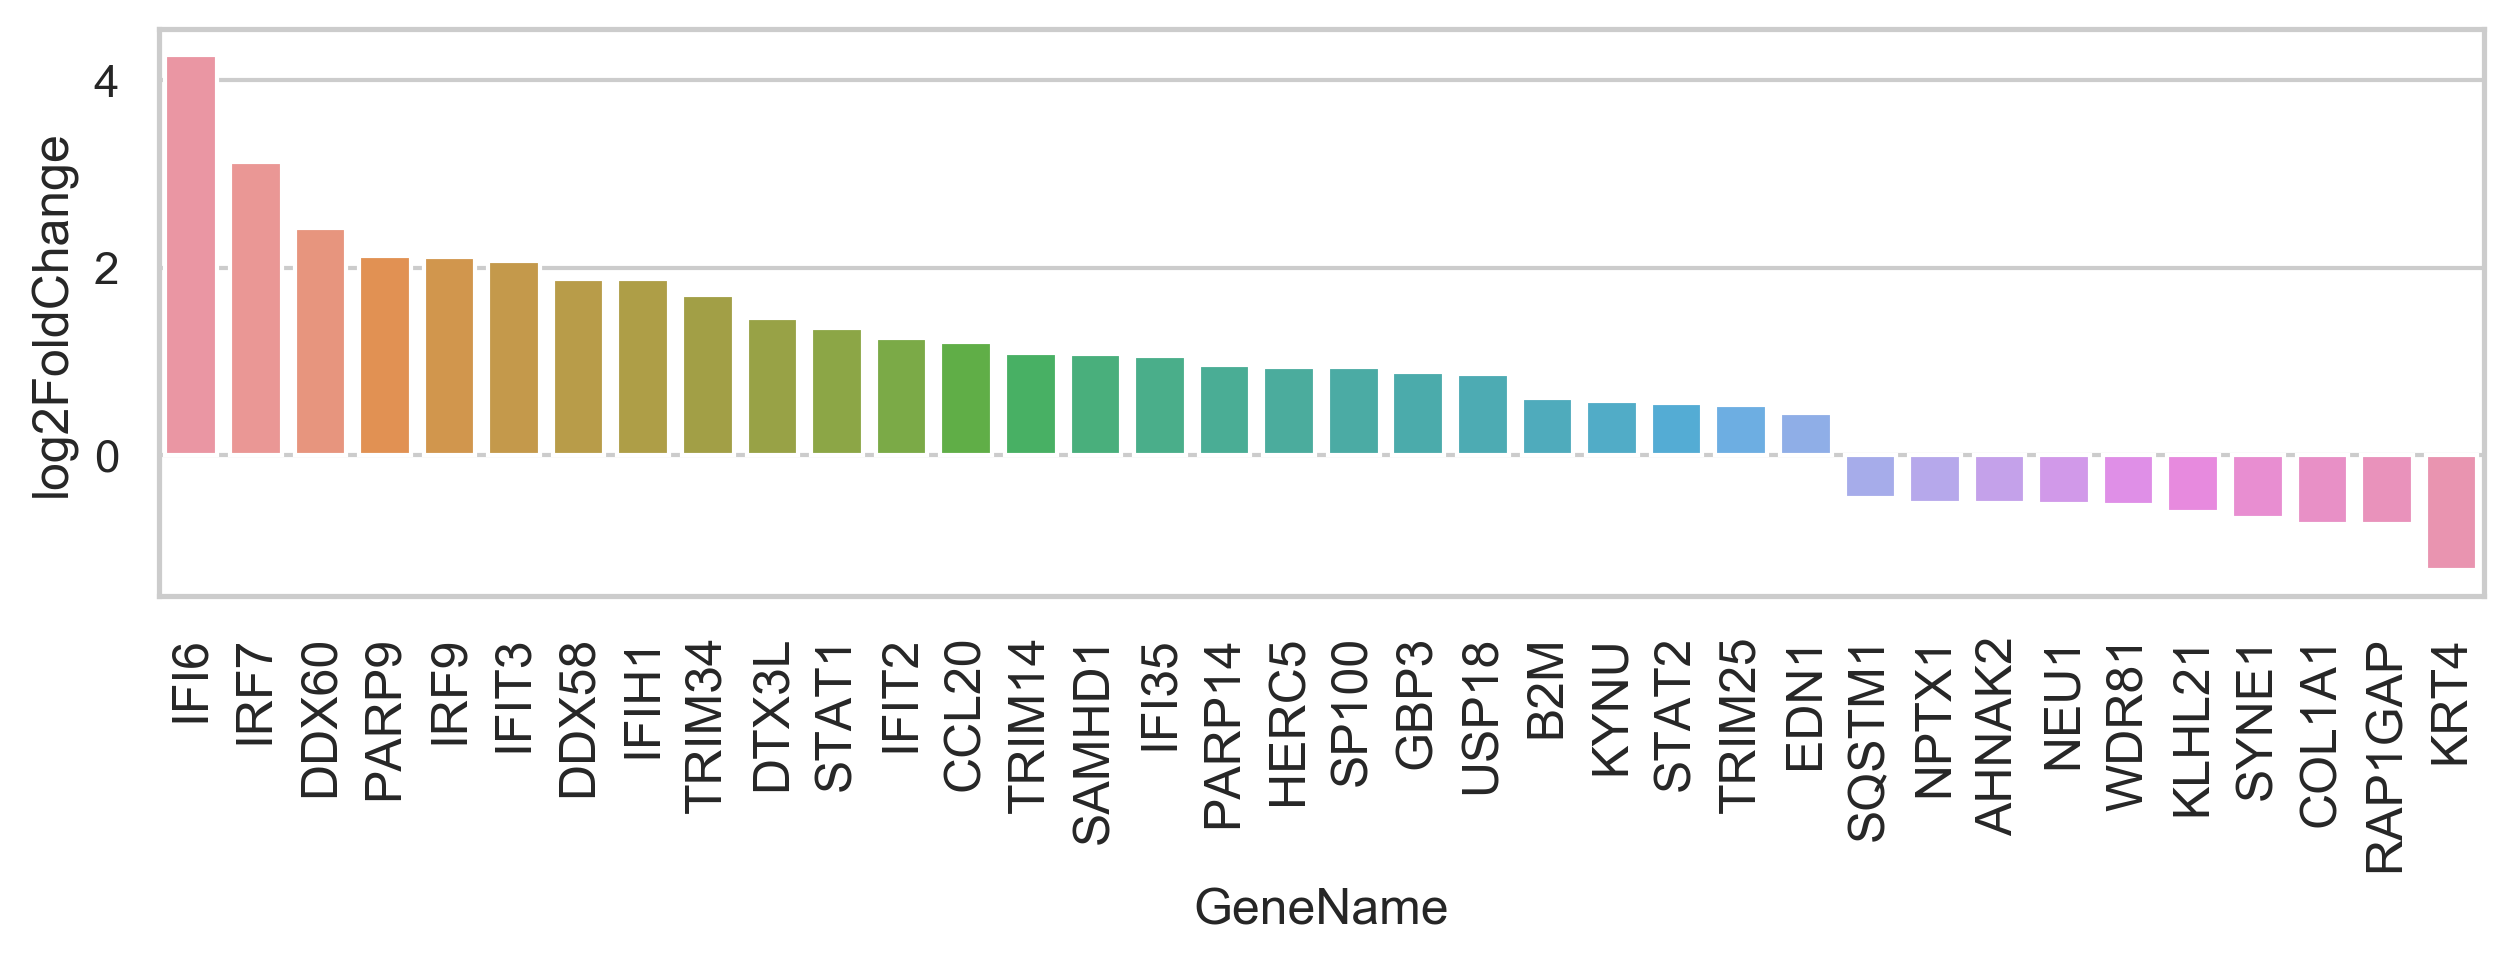

In [17]:
import seaborn as sns
import matplotlib as mpl

fig, ax = plt.subplots(figsize=(10,2.5), dpi=300)
sns.barplot(y='log2FoldChange', x='GeneName',data=df_p, ax=ax)
mpl.rcParams['xtick.major.pad']='0'
mpl.rcParams['xtick.minor.pad']='0'
ax.set_xticklabels(df_p['GeneName'].values, rotation=90, fontsize=12)

plt.savefig('../figures/antiviral.36genes.logFC.png', dpi=300, bbox_inches='tight')

## testing

In [18]:
np.all(enr_sel['intersection_size']/enr_sel['query_size'] == enr_sel['precision'])

True

In [19]:
np.all(enr_sel['intersection_size']/enr_sel['term_size'] == enr_sel['recall'])

True

In [20]:
enr_sel


,source,native,name,p_value,significant,description,term_size,query_size,intersection_size,effective_domain_size,precision,recall,query,parents
8,GO:CC,GO:0044753,amphisome,0.023454,True,"""Intermediate organelles formed during macroau...",2,14,1,18856,0.071429,0.500000,query_1,[GO:0005776]
9,GO:CC,GO:0005584,collagen type I trimer,0.023454,True,"""A collagen trimer containing alpha(I) chains....",2,14,1,18856,0.071429,0.500000,query_1,[GO:0005583]
10,GO:CC,GO:0000932,P-body,0.026533,True,"""A focus in the cytoplasm where mRNAs may beco...",87,14,2,18856,0.142857,0.022989,query_1,[GO:0036464]
11,GO:CC,GO:0005776,autophagosome,0.028931,True,"""A double-membrane-bounded compartment that en...",95,14,2,18856,0.142857,0.021053,query_1,[GO:0005773]
5,GO:CC,GO:0030017,sarcomere,0.011270,True,"""The repeating unit of a myofibril in a muscle...",206,14,3,18856,0.214286,0.014563,query_1,"[GO:0030016, GO:0110165]"
6,GO:CC,GO:0030016,myofibril,0.013157,True,"""The contractile element of skeletal and cardi...",229,14,3,18856,0.214286,0.013100,query_1,[GO:0043292]
7,GO:CC,GO:0043292,contractile fiber,0.013196,True,"""Fibers, composed of actin, myosin, and associ...",240,14,3,18856,0.214286,0.012500,query_1,"[GO:0005737, GO:0043232, GO:0099512]"
0,GO:CC,GO:0099512,supramolecular fiber,0.003660,True,"""A polymer consisting of an indefinite number ...",995,14,6,18856,0.428571,0.006030,query_1,[GO:0099081]
1,GO:CC,GO:0099081,supramolecular polymer,0.003660,True,"""A polymeric supramolecular structure."" [GOC:dos]",1003,14,6,18856,0.428571,0.005982,query_1,[GO:0099080]
4,GO:CC,GO:0099080,supramolecular complex,0.006489,True,"""A cellular component that consists of an inde...",1310,14,6,18856,0.428571,0.004580,query_1,[GO:0110165]


# Table S2. Match antiviral 36 genes to antiviral related GO terms

In [34]:
import pandas as pd
ref = pd.read_csv('../data/cmap/antiviral36.GO2Gene.csv',header=None, names=['db','term','id','genes'])
ref

,db,term,id,genes
0,GO:BP,defense response to virus,GO:0051607,"ADAR,DDX58,DDX60,DTX3L,EIF2AK2,GBP3,HERC5,IFI1..."
1,GO:BP,type I interferon signaling pathway,GO:0060337,"ADAR,IFI27,IFI35,IFI6,IFIT1,IFIT2,IFIT3,IFITM1..."
2,GO:BP,cellular response to type I interferon,GO:0071357,"ADAR,IFI27,IFI35,IFI6,IFIT1,IFIT2,IFIT3,IFITM1..."
3,GO:BP,response to type I interferon,GO:0034340,"ADAR,IFI27,IFI35,IFI6,IFIT1,IFIT2,IFIT3,IFITM1..."
4,GO:BP,negative regulation of viral process,GO:0048525,"EIF2AK2,IFI16,IFIT1,IFIT5,IFITM1,IFITM3,ISG15,..."
5,GO:BP,negative regulation of viral genome replication,GO:0045071,"EIF2AK2,IFI16,IFIT1,IFIT5,IFITM1,IFITM3,ISG15,..."
6,GO:BP,negative regulation of viral life cycle,GO:1903901,"EIF2AK2,IFI16,IFIT1,IFIT5,IFITM1,IFITM3,ISG15,..."
7,GO:BP,response to interferon-gamma,GO:0034341,"B2M,CCL20,EDN1,GBP3,IFITM1,IFITM3,IRF7,IRF9,KY..."
8,GO:BP,interferon-gamma-mediated signaling pathway,GO:0060333,"B2M,IRF7,IRF9,OAS1,OAS2,OAS3,OASL,PARP14,PARP9..."
9,GO:BP,cellular response to interferon-gamma,GO:0071346,"B2M,CCL20,EDN1,GBP3,IRF7,IRF9,OAS1,OAS2,OAS3,O..."


In [37]:
ts1 = pd.read_csv('../../manuscript/SuppTables/Table S1. Differentially expressed genes of A549 cells after SARS-CoV-2 infection.csv')
ts2 = pd.read_csv('../../manuscript/SuppTables/Table S2. Anti-viral gene signature with 36 DEGs.csv')
ts1.head(3),ts2.head(3)

(  GeneName                                        ProteinName  log2FoldChange  \
 0      MX1         Interferon-induced GTP-binding protein Mx1            5.20   
 1    IFI44           Interferon-induced protein 44 (Fragment)            4.59   
 2    IFIT1  Interferon-induced protein with tetratricopept...            4.43   
 
           pvalue          padj  
 0   2.560000e-97  1.160000e-93  
 1   2.800000e-06  6.800000e-04  
 2  9.070000e-100  6.180000e-96  ,
   Gene name    Protein name Database               Term   GO Number
 0    AHNAK2  Protein AHNAK2    GO:CC          myofibril  GO:0030016
 1    AHNAK2  Protein AHNAK2    GO:CC            vesicle  GO:0031982
 2    AHNAK2  Protein AHNAK2    GO:CC  contractile fiber  GO:0043292)

In [45]:
ts = pd.merge(ts1.loc[:,['GeneName','log2FoldChange']], ts2, left_on='GeneName',right_on='Gene name')
ts = ts.sort_values('log2FoldChange', ascending=False)
ts = ts[['Gene name','Protein name','log2FoldChange','Database','Term','GO Number']]
ts

,Gene name,Protein name,log2FoldChange,Database,Term,GO Number
0,IFI6,Interferon alpha-inducible protein 6,4.27,GO:BP,type I interferon signaling pathway,GO:0060337
3,IFI6,Interferon alpha-inducible protein 6,4.27,GO:BP,defense response to virus,GO:0051607
1,IFI6,Interferon alpha-inducible protein 6,4.27,GO:BP,cellular response to type I interferon,GO:0071357
2,IFI6,Interferon alpha-inducible protein 6,4.27,GO:BP,response to type I interferon,GO:0034340
4,IRF7,"Interferon regulatory factor 7, isoform CRA_a",3.13,GO:BP,cellular response to interferon-gamma,GO:0071346
...,...,...,...,...,...,...
161,RAP1GAP,Rap1 GTPase-activating protein 1,-0.74,GO:CC,vesicle,GO:0031982
162,RAP1GAP,Rap1 GTPase-activating protein 1,-0.74,GO:CC,intracellular vesicle,GO:0097708
163,KRT4,"Keratin, type II cytoskeletal 4",-1.23,GO:CC,supramolecular fiber,GO:0099512
164,KRT4,"Keratin, type II cytoskeletal 4",-1.23,GO:CC,supramolecular polymer,GO:0099081


In [47]:
ts.to_csv('../../manuscript/SuppTables/nTable S2. Anti-viral gene signature with 36 DEGs.csv', index=False)